# Learning MuJoCo
Below is a tutorial to help you better understand xml file structure.

## Setup Code / Packages

In [ ]:
!pip install mujoco
!pip install -q mediapy


## Import Libraries

In [35]:
import mujoco as mj
import mediapy as media

# Helper Functions
Run this block.

In [ ]:
def render(xml):
    model = mj.MjModel.from_xml_string(xml)
    data = mj.MjData(model)

    with mj.Renderer(model) as renderer:
        mj.mj_forward(model, data)
        renderer.update_scene(data)

        media.show_image(renderer.render())

def render_scene(xml):
    scene = mj.MjvScene() #3d scene rendering
    scene.flags[mj.mjtRndFlag.mjRND_SHADOW] = False

    scene_option = mj.MjvOption() #visualization options
    scene_option.frame = mj.mjtFrame.mjFRAME_WORLD
    scene_option.flags[mj.mjtVisFlag.mjVIS_JOINT] = True


    model = mj.MjModel.from_xml_string(xml)
    data = mj.MjData(model)

    with mj.Renderer(model) as renderer:
        mj.mj_forward(model, data)
        renderer.update_scene(data, scene_option=scene_option)

        media.show_image(renderer.render())

def launch_sim(xml):
    model = mj.MjModel.from_xml_string(xml)
    data = mj.MjData(model) 
    
    try:
        with mj.viewer.launch(model, data) as viewer:
            while viewer.is_running():
                mj.mj_step(model, data)
                viewer.sync()
    except:
        print("Exiting simulation loop.")


## Mujoco basics
Models are defined in MuJoCo's [MJCF](http://www.mujoco.org/book/modeling.html), which is an [XML](https://en.wikipedia.org/wiki/XML#Key_terminology)-based modeling language. See [XML Reference](https://mujoco.readthedocs.io/en/stable/XMLreference.html#option) for documentation.

We will begin by stepping through the definition of a humanoid model that can be found [here](https://github.com/google-deepmind/mujoco/blob/main/model/humanoid/humanoid.xml).

In [3]:
xml = """ 
<mujoco>
    <option timestep="0.005" gravity="0 0 0"/>

"""

The only required element is `<mujoco/>`. 

The `<option>` element is used to configure global settings for the simulation.
- `timestep` defines the simulation timestep in seconds. i.e. How frequently the simulation updates
    - Smaller timesteps increase accuracy but require more computation. 

- `gravity` specifies a gravity vector in world coordinates $(x,y,z)$ (in meters per second squared).
    - gravity on earth would be `gravity="0 0 -9.81"`.


In [4]:
xml += """ 
  <visual>
    <map force="0.1" zfar="30"/>
    <rgba haze="0.15 0.25 0.35 1"/>
    <global offwidth="2560" offheight="1440" elevation="-20" azimuth="120"/>
  </visual>
"""

The `<visual>` element defines properties related to the visualizer of the rendered environment.

In [5]:
xml += """ 
<statistic center="0 0 0.7"/>
"""

The `<statistic>` element is used for gathering statistical information about the simulation or setting default visualization parameters.
- `center` sets the coordinates of the center point of the bounding box for the entire model in the inital configuration.

In [6]:
xml += """
<asset>
    <texture type="skybox" builtin="gradient" rgb1=".3 .5 .7" rgb2="0 0 0" width="32" height="512"/>
    <texture name="body" type="cube" builtin="flat" mark="cross" width="128" height="128" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" markrgb="1 1 1"/>
    <material name="body" texture="body" texuniform="true" rgba="0.8 0.6 .4 1"/>
    <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="1 1" texuniform="true" reflectance=".2"/>
  </asset>
"""

`<asset>` is a grouping element for defining assets that can be referenced from other model elements.
- The `texture` element is referenced from a `material` asset used to define visual textures that can be applied to objects. 
- The `material` asset can be referenced from [skins](https://mujoco.readthedocs.io/en/stable/XMLreference.html#deformable-skin), [geoms](https://mujoco.readthedocs.io/en/stable/XMLreference.html#body-geom), [sites](https://mujoco.readthedocs.io/en/stable/XMLreference.html#body-site), and [tendons](https://mujoco.readthedocs.io/en/stable/XMLreference.html#tendon) to set their appearance. 


In [7]:
xml += """
<default>
    <motor ctrlrange="-1 1" ctrllimited="true"/>
    <default class="body">
"""

The `<default>` element is used to specify the default properties of elements. This allows us to set common shared properties in one place and avoid redundancy. 

In [8]:
xml += """    
<geom type="capsule" condim="1" friction=".7" solimp=".9 .99 .003" solref=".015 1" material="body" group="1"/>
      <default class="thigh">
        <geom size=".06"/>
      </default>
      <default class="shin">
        <geom fromto="0 0 0 0 0 -.3"  size=".049"/>
      </default>
      <default class="foot">
        <geom size=".027"/>
        <default class="foot1">
          <geom fromto="-.07 -.01 0 .14 -.03 0"/>
        </default>
        <default class="foot2">
          <geom fromto="-.07 .01 0 .14  .03 0"/>
        </default>
      </default>
      <default class="arm_upper">
        <geom size=".04"/>
      </default>
      <default class="arm_lower">
        <geom size=".031"/>
      </default>
      <default class="hand">
        <geom type="sphere" size=".04"/>
      </default>
"""

Here we define the default geometry properties for different body parts of the model defined by class. 

[**geoms**](https://mujoco.readthedocs.io/en/stable/XMLreference.html#body-geom) are the fundamental building blocks in MuJoCo that define the shape of objects in the simulation.

**Note**: nested default tags inherit properties from its parent tag. 

**Note:** By defining a geom within a `<default>` tag like so:
```python 
"""
<default>
    <geom type="capsule" condim="1" friction=".7" solimp=".9 .99 .003" solref=".015 1" material="body" group="1"/>
</default>
"""
```

We are setting the default configuration for any geom to be a capsule with the provided attributes if not explicitly set.

In [9]:
xml += """
<joint type="hinge" damping=".2" stiffness="1" armature=".01" limited="true" solimplimit="0 .99 .01"/>
      <default class="joint_big">
        <joint damping="5" stiffness="10"/>
        <default class="hip_x">
          <joint range="-30 10"/>
        </default>
        <default class="hip_z">
          <joint range="-60 35"/>
        </default>
        <default class="hip_y">
          <joint axis="0 1 0" range="-150 20"/>
        </default>
        <default class="joint_big_stiff">
          <joint stiffness="20"/>
        </default>
      </default>
      <default class="knee">
        <joint pos="0 0 .02" axis="0 -1 0" range="-160 2"/>
      </default>
      <default class="ankle">
        <joint range="-50 50"/>
        <default class="ankle_y">
          <joint pos="0 0 .08" axis="0 1 0" stiffness="6"/>
        </default>
        <default class="ankle_x">
          <joint pos="0 0 .04" stiffness="3"/>
        </default>
      </default>
      <default class="shoulder">
        <joint range="-85 60"/>
      </default>
      <default class="elbow">
        <joint range="-100 50" stiffness="0"/>
      </default>
    </default>
  </default>
"""

Next we define the default joint properties for each class within the model.

We add DOFs by addings [**joints**](https://mujoco.readthedocs.io/en/stable/XMLreference.html#body-joint) to rigid bodies. They specify how they can move with respect to their parent bodies. 

**Note:** By defining a joint within a `<default>` tag like so:
```python 
"""
<default>
    <joint type="hinge" damping=".2" stiffness="1" armature=".01" limited="true" solimplimit="0 .99 .01"/>
</default>
"""
```

We are setting the default configuration for any joint to be a hinge with the provided attributes if not explicitly set.

In [36]:
xml += """
<worldbody>
    <geom name="floor" size="0 0 .05" type="plane" material="grid" condim="3"/>
    <light name="top" pos="0 0 2" mode="trackcom"/>
    <light name="spotlight" mode="targetbodycom" diffuse=".8 .8 .8" specular="0.3 0.3 0.3" pos="0 -6 4" cutoff="30"/>
"""

`<worldbody>` is the top-level body that corresponds to the world frame and environment. This is used to construct the [kinematic tree](https://mujoco.readthedocs.io/en/stable/modeling.html#kinematic-tree) via nesting. More details below.

Here we create the floor of the simulation with a plane. We create a toplight and spotlight to illuminate the scene. 

At this point we have not created any objects in our simulator. We simply defined properties of the visualizer, the environment, and default configurations of body parts that we will implement in the next part.

""

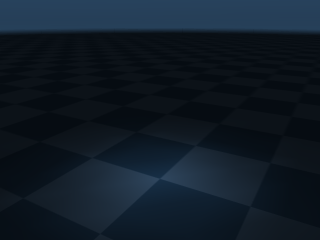

In [11]:
xml_ = xml + """</worldbody></mujoco>""" #Must close tags to be valid xml
render(xml_)

Now we will define our humanoid model. We will begin with the root of the subtree, the **torso**, and implement each set of body parts individually. 
At the end we will appropriately append each body to the root and demonstrate how the kinematic tree is constructed. 

As we walk through this implementation, keep in mind the properties that we set for `<geom>` and `<joint>` elements. Declaring `childclass="body"` allows the default properties for child elements to be inherited from the specified `class`.

In [12]:
torso = xml + """
    <body name="torso" pos="0 0 1.282" childclass="body">
      <freejoint name="root"/>
      <geom name="torso" fromto="0 -.07 0 0 .07 0" size=".07"/>
      <geom name="waist_upper" fromto="-.01 -.06 -.12 -.01 .06 -.12" size=".06"/>
      <body name="head" pos="0 0 .19">
        <geom name="head" type="sphere" size=".09"/>
      </body>
    </body>
 </worldbody>
</mujoco>
"""


The `<body>` tag **torso** will be the root of our subtree. This is where we will attach other body parts via nesting.

The `<freejoint>` is a special type of joint that gives the associated body full mobility. Unlike other joints that connect two rigid bodies and constrain their relative motion, the free joint provides full mobility in the global space. 
- The `<freejoint>` defines 6 DOFs: 3 translations $(x,y,z)$ + 3 rotations about these axes.

We define geometries for the torso and part of the waist. These are welded together in the order they are defined. We create a separate `<body>` for the head so that we may position the object to be above the torso. The entire block becomes one rigid body that is free to move and rotate. 

The `pos` attribute of a `<body>` defines the location of the body relative to its parent body. The position refers the center of mass. 

Total number of DoFs in the model: 6


""

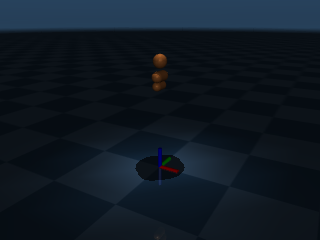

In [13]:
model_ = mj.MjModel.from_xml_string(torso)
print('Total number of DoFs in the model:', model_.nv)

render_scene(torso)

We've rendered the scene and visualized the axes within the worldbody. 
- **Red**: x-axis
- **Green**: y-axis
- **Blue**: z-axis 


Next we will define the lower waist, pelvis, butt, thighs, shins, and feet.

""

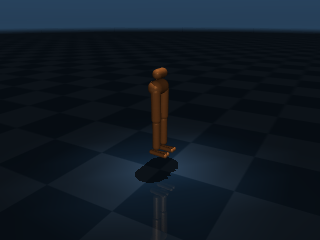

In [14]:
legs = xml + """
    <body name="waist_lower" pos="0 0 1.282" childclass="body">
      <geom name="waist_lower" fromto="0 -.06 0 0 .06 0" size=".06"/>
      <joint name="abdomen_z" pos="0 0 .065" axis="0 0 1" range="-45 45" class="joint_big_stiff"/>
      <joint name="abdomen_y" pos="0 0 .065" axis="0 1 0" range="-75 30" class="joint_big"/>
      <body name="pelvis" pos="0 0 -.165">
        <joint name="abdomen_x" pos="0 0 .1" axis="1 0 0" range="-35 35" class="joint_big"/>
        <geom name="butt" fromto="-.02 -.07 0 -.02 .07 0" size=".09"/>
        <body name="thigh_right" pos="0 -.1 -.04">
          <joint name="hip_x_right" axis="1 0 0" class="hip_x"/>
          <joint name="hip_z_right" axis="0 0 1" class="hip_z"/>
          <joint name="hip_y_right" class="hip_y"/>
          <geom name="thigh_right" fromto="0 0 0 0 .01 -.34" class="thigh"/>
          <body name="shin_right" pos="0 .01 -.4">
            <joint name="knee_right" class="knee"/>
            <geom name="shin_right" class="shin"/>
            <body name="foot_right" pos="0 0 -.39">
              <joint name="ankle_y_right" class="ankle_y"/>
              <joint name="ankle_x_right" class="ankle_x" axis="1 0 .5"/>
              <geom name="foot1_right" class="foot1"/>
              <geom name="foot2_right" class="foot2"/>
            </body>
          </body>
        </body>
        <body name="thigh_left" pos="0 .1 -.04">
          <joint name="hip_x_left" axis="-1 0 0" class="hip_x"/>
          <joint name="hip_z_left" axis="0 0 -1" class="hip_z"/>
          <joint name="hip_y_left" class="hip_y"/>
          <geom name="thigh_left" fromto="0 0 0 0 -.01 -.34" class="thigh"/>
          <body name="shin_left" pos="0 -.01 -.4">
            <joint name="knee_left" class="knee"/>
            <geom name="shin_left" fromto="0 0 0 0 0 -.3" class="shin"/>
            <body name="foot_left" pos="0 0 -.39">
              <joint name="ankle_y_left" class="ankle_y"/>
              <joint name="ankle_x_left" class="ankle_x" axis="-1 0 -.5"/>
              <geom name="foot1_left" class="foot1"/>
              <geom name="foot2_left" class="foot2"/>
            </body>
          </body>
        </body>
      </body>
    </body>
  </worldbody>
"""

render(legs + "</mujoco>")

**Note:** A hinge joint adds one rotational DOF. The `axis` attribute specfies the direction of the rotation axis in 3D space. 
- E.x. `axis="0 0 1"` specifies rotation around the z axis.
- E.x. `axis="1 0 0.5"` specifies rotation around the vector (starting from the origin) that lives
    - 1 unit in the x-direction and 0.5 units in the z-direction

The `pos` attribute of a `<joint>` tag specifies the location of the joint in the local frame of the parent body. This will be the pivot point around which the body will rotate or move

Now let's add some [motors](https://mujoco.readthedocs.io/en/latest/XMLreference.html#actuator-motor) to interact with the joints. 

In [15]:
legs += """
<actuator>
    <motor name="abdomen_z"       gear="40"  joint="abdomen_z"/>
    <motor name="abdomen_y"       gear="40"  joint="abdomen_y"/>
    <motor name="abdomen_x"       gear="40"  joint="abdomen_x"/>
    <motor name="hip_x_right"     gear="40"  joint="hip_x_right"/>
    <motor name="hip_z_right"     gear="40"  joint="hip_z_right"/>
    <motor name="hip_y_right"     gear="120" joint="hip_y_right"/>
    <motor name="knee_right"      gear="80"  joint="knee_right"/>
    <motor name="ankle_y_right"   gear="20"  joint="ankle_y_right"/>
    <motor name="ankle_x_right"   gear="20"  joint="ankle_x_right"/>
    <motor name="hip_x_left"      gear="40"  joint="hip_x_left"/>
    <motor name="hip_z_left"      gear="40"  joint="hip_z_left"/>
    <motor name="hip_y_left"      gear="120" joint="hip_y_left"/>
    <motor name="knee_left"       gear="80"  joint="knee_left"/>
    <motor name="ankle_y_left"    gear="20"  joint="ankle_y_left"/>
    <motor name="ankle_x_left"    gear="20"  joint="ankle_x_left"/>
</actuator>
</mujoco>
"""

**Abdomen Joints (Spine)**:
- **abdomen_z**: Allows the waist to rotate along the vertical axis (twisting motion)
- **abdomen_y**: Simulates forward/backward bending of the waist
- **abdomen_x**: Allows sideways bending of the waist

**Pelvis and Hips**:
- **hip_x**: Rotation around the front-back axis (e.g. lifting the leg to the side)
- **hip_z**: Rotation around the vertical axis (e.g. turning the leg outward or inward)
- **hip_y**: Sideways motion of the leg (e.g. leg swinging forward or backward)

**Knees**:
- **knee_right**, **knee_left**: Enables Knee to bend and extend in one direction

**Ankles**:
- **ankle_y**: Up/down movement (dorsiflexion and plantarflexion)  
- **ankle_x**: Side-to-side movement (inversion and eversion)


Run the following block to launch the MuJoCo simulator in an external window. 

Navigate to the `Control` section on the right side and interact with the motors.

In [16]:
launch_sim(legs)


Exiting simulation loop.


Next we will define the arms and hands . 

""

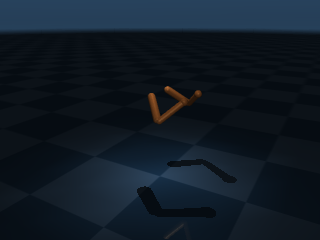

In [17]:
arms = xml + """
    <body name="upper_arm_right" pos="0 -.17 1">
      <joint name="shoulder1_right" axis="2 1 1"  class="shoulder"/>
      <joint name="shoulder2_right" axis="0 -1 1" class="shoulder"/>
      <geom name="upper_arm_right" fromto="0 0 0 .16 -.16 -.16" class="arm_upper"/>
      <body name="lower_arm_right" pos=".18 -.18 -.18">
        <joint name="elbow_right" axis="0 -1 1" class="elbow"/>
        <geom name="lower_arm_right" fromto=".01 .01 .01 .17 .17 .17" class="arm_lower"/>
        <body name="hand_right" pos=".18 .18 .18">
          <geom name="hand_right" zaxis="1 1 1" class="hand"/>
        </body>
      </body>
    </body>
      <body name="upper_arm_left" pos="0 .17 1">
        <joint name="shoulder1_left" axis="-2 1 -1" class="shoulder"/>
        <joint name="shoulder2_left" axis="0 -1 -1"  class="shoulder"/>
        <geom name="upper_arm_left" fromto="0 0 0 .16 .16 -.16" class="arm_upper"/>
        <body name="lower_arm_left" pos=".18 .18 -.18">
          <joint name="elbow_left" axis="0 -1 -1" class="elbow"/>
          <geom name="lower_arm_left" fromto=".01 -.01 .01 .17 -.17 .17" class="arm_lower"/>
          <body name="hand_left" pos=".18 -.18 .18">
            <geom name="hand_left" zaxis="1 -1 1" class="hand"/>
          </body>
        </body>
    </body>
  </worldbody>
"""

render(arms +"</mujoco>")


In [18]:
arms += """
<actuator>
    <motor name="shoulder1_right" gear="20"  joint="shoulder1_right"/>
    <motor name="shoulder2_right" gear="20"  joint="shoulder2_right"/>
    <motor name="elbow_right"     gear="40"  joint="elbow_right"/>
    <motor name="shoulder1_left"  gear="20"  joint="shoulder1_left"/>
    <motor name="shoulder2_left"  gear="20"  joint="shoulder2_left"/>
    <motor name="elbow_left"      gear="40"  joint="elbow_left"/>
</actuator>
</mujoco>
"""

**Shoulders**:
- **shoulder_1**: Allows the upper arm to move up and down (e.g. lateral raise)
- **shoulder_2**: Provides sideways and rotational motion of the upper arm (e.g. arm circles)

**Elbows**:
- **elbow**: Enables lower arm to bend and extend

In [34]:
launch_sim(arms)

Exiting simulation loop.


With that we have now created each component of our humanoid model. Let's put it all together and make some position adjustments for the final result.

""

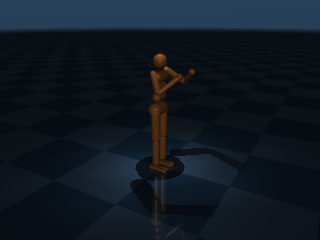

In [20]:
humanoid = xml + """
    <body name="torso" pos="0 0 1.282" childclass="body">
      <freejoint name="root"/>
      <geom name="torso" fromto="0 -.07 0 0 .07 0" size=".07"/>
      <geom name="waist_upper" fromto="-.01 -.06 -.12 -.01 .06 -.12" size=".06"/>
      <body name="head" pos="0 0 .19">
        <geom name="head" type="sphere" size=".09"/>
      </body>
      <body name="waist_lower" pos="-.01 0 -.26">
        <geom name="waist_lower" fromto="0 -.06 0 0 .06 0" size=".06"/>
        <joint name="abdomen_z" pos="0 0 .065" axis="0 0 1" range="-45 45" class="joint_big_stiff"/>
        <joint name="abdomen_y" pos="0 0 .065" axis="0 1 0" range="-75 30" class="joint_big"/>
        <body name="pelvis" pos="0 0 -.165">
          <joint name="abdomen_x" pos="0 0 .1" axis="1 0 0" range="-35 35" class="joint_big"/>
          <geom name="butt" fromto="-.02 -.07 0 -.02 .07 0" size=".09"/>
          <body name="thigh_right" pos="0 -.1 -.04">
            <joint name="hip_x_right" axis="1 0 0" class="hip_x"/>
            <joint name="hip_z_right" axis="0 0 1" class="hip_z"/>
            <joint name="hip_y_right" class="hip_y"/>
            <geom name="thigh_right" fromto="0 0 0 0 .01 -.34" class="thigh"/>
            <body name="shin_right" pos="0 .01 -.4">
              <joint name="knee_right" class="knee"/>
              <geom name="shin_right" class="shin"/>
              <body name="foot_right" pos="0 0 -.39">
                <joint name="ankle_y_right" class="ankle_y"/>
                <joint name="ankle_x_right" class="ankle_x" axis="1 0 .5"/>
                <geom name="foot1_right" class="foot1"/>
                <geom name="foot2_right" class="foot2"/>
              </body>
            </body>
          </body>
          <body name="thigh_left" pos="0 .1 -.04">
            <joint name="hip_x_left" axis="-1 0 0" class="hip_x"/>
            <joint name="hip_z_left" axis="0 0 -1" class="hip_z"/>
            <joint name="hip_y_left" class="hip_y"/>
            <geom name="thigh_left" fromto="0 0 0 0 -.01 -.34" class="thigh"/>
            <body name="shin_left" pos="0 -.01 -.4">
              <joint name="knee_left" class="knee"/>
              <geom name="shin_left" fromto="0 0 0 0 0 -.3" class="shin"/>
              <body name="foot_left" pos="0 0 -.39">
                <joint name="ankle_y_left" class="ankle_y"/>
                <joint name="ankle_x_left" class="ankle_x" axis="-1 0 -.5"/>
                <geom name="foot1_left" class="foot1"/>
                <geom name="foot2_left" class="foot2"/>
              </body>
            </body>
          </body>
        </body>
      </body>
      <body name="upper_arm_right" pos="0 -.17 .06">
        <joint name="shoulder1_right" axis="2 1 1"  class="shoulder"/>
        <joint name="shoulder2_right" axis="0 -1 1" class="shoulder"/>
        <geom name="upper_arm_right" fromto="0 0 0 .16 -.16 -.16" class="arm_upper"/>
        <body name="lower_arm_right" pos=".18 -.18 -.18">
          <joint name="elbow_right" axis="0 -1 1" class="elbow"/>
          <geom name="lower_arm_right" fromto=".01 .01 .01 .17 .17 .17" class="arm_lower"/>
          <body name="hand_right" pos=".18 .18 .18">
            <geom name="hand_right" zaxis="1 1 1" class="hand"/>
          </body>
        </body>
      </body>
      <body name="upper_arm_left" pos="0 .17 .06">
        <joint name="shoulder1_left" axis="-2 1 -1" class="shoulder"/>
        <joint name="shoulder2_left" axis="0 -1 -1"  class="shoulder"/>
        <geom name="upper_arm_left" fromto="0 0 0 .16 .16 -.16" class="arm_upper"/>
        <body name="lower_arm_left" pos=".18 .18 -.18">
          <joint name="elbow_left" axis="0 -1 -1" class="elbow"/>
          <geom name="lower_arm_left" fromto=".01 -.01 .01 .17 -.17 .17" class="arm_lower"/>
          <body name="hand_left" pos=".18 -.18 .18">
            <geom name="hand_left" zaxis="1 -1 1" class="hand"/>
          </body>
        </body>
      </body>
    </body>
  </worldbody>
"""

render(humanoid + "</mujoco>")

**Kinematic tree**:
```text
torso (6 DOFS)
  ├── geom: torso
  ├── geom: waist_upper
  ├── head
  │     └── geom: head
  ├── waist_lower (2 DOFS)
  │     ├── geom: waist_lower
  │     ├── joint: abdomen_z
  │     ├── joint: abdomen_y
  │     └── pelvis (1 DOF)
  │           ├── joint: abdomen_x
  │           ├── geom: butt
  │           ├── thigh_right (3 DOFS)
  │           │     ├── joint: hip_x_right
  │           │     ├── joint: hip_z_right
  │           │     ├── joint: hip_y_right
  │           │     ├── geom: thigh_right
  │           │     └── shin_right (1 DOF)
  │           │           ├── joint: knee_right
  │           │           ├── geom: shin_right
  │           │           └── foot_right (2 DOFS)
  │           │                 ├── joint: ankle_y_right
  │           │                 ├── joint: ankle_x_right
  │           │                 ├── geom: foot1_right
  │           │                 └── geom: foot2_right
  │           └── thigh_left (3 DOFS)
  │                 ├── joint: hip_x_left
  │                 ├── joint: hip_z_left
  │                 ├── joint: hip_y_left
  │                 ├── geom: thigh_left
  │                 └── shin_left (1 DOF)
  │                       ├── joint: knee_left
  │                       ├── geom: shin_left
  │                       └── foot_left (2 DOFS)
  │                             ├── joint: ankle_y_left
  │                             ├── joint: ankle_x_left
  │                             ├── geom: foot1_left
  │                             └── geom: foot2_left
  ├── upper_arm_right (2 DOFS)
  │     ├── joint: shoulder1_right
  │     ├── joint: shoulder2_right
  │     ├── geom: upper_arm_right
  │     └── lower_arm_right (1 DOF)
  │           ├── joint: elbow_right
  │           ├── geom: lower_arm_right
  │           └── hand_right
  │                 └── geom: hand_right
  └── upper_arm_left (2 DOFS)
        ├── joint: shoulder1_left
        ├── joint: shoulder2_left
        ├── geom: upper_arm_left
        └── lower_arm_left (1 DOF)
              ├── joint: elbow_left
              ├── geom: lower_arm_left
              └── hand_left
                    └── geom: hand_left
```
